In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

## Data Loading

In [2]:
folders = [
    "dataset/finger_1/",
    "dataset/finger_2/",
    "dataset/finger_3/",
    "dataset/finger_4/",
    "dataset/finger_5/",
]

labels = [os.path.basename(folder[:-1]) for folder in folders]
data = []
labels = []
file_name = []

target_size = (150, 150)

for folder in folders:
    label = os.path.basename(folder[:-1])
    if not os.path.exists(folder):
        print(f"Folder {folder} tidak ditemukan.")
        continue
    dataset = os.listdir(folder)
    for file in dataset:
        img_path = os.path.join(folder, file)
        name = os.path.splitext(file)[0]
        temp = cv.imread(img_path)
        if temp is None:
            print(f"Gagal membaca gambar {img_path}")
            continue
        gray_img = cv.cvtColor(temp, cv.COLOR_BGR2GRAY)
        resized_img = cv.resize(gray_img, target_size)
        data.append(resized_img)
        labels.append(label)
        file_name.append(name)

Total jumlah data: 2164
Distribusi data:

finger_1: 435 images
finger_2: 432 images
finger_3: 432 images
finger_4: 433 images
finger_5: 432 images


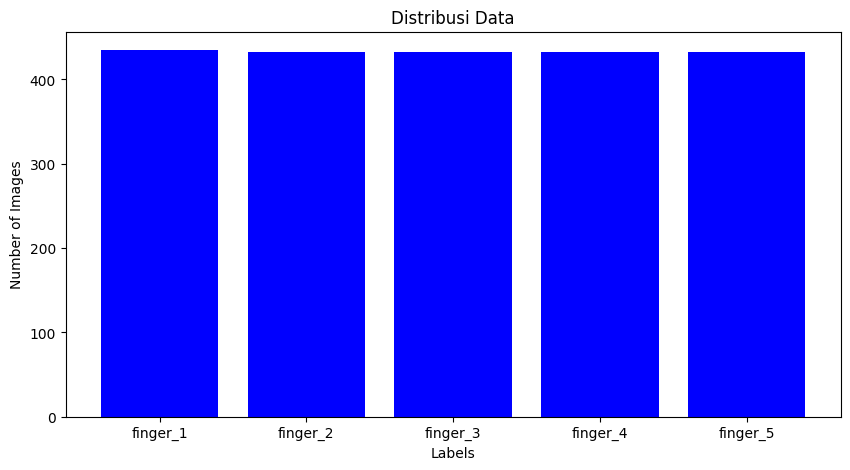

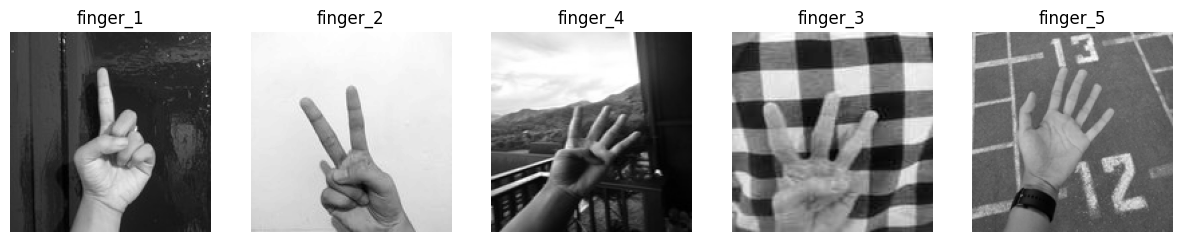

Karakteristik data:
Sample 1 - Label: finger_1
  - Ukuran: (150, 150)
  - Nilai piksel min: 11, max: 188
  - Mean piksel: 157.42653333333334
  - Std piksel: 32.62494448499321

Sample 2 - Label: finger_1
  - Ukuran: (150, 150)
  - Nilai piksel min: 16, max: 185
  - Mean piksel: 118.15133333333333
  - Std piksel: 18.101113176327644

Sample 3 - Label: finger_1
  - Ukuran: (150, 150)
  - Nilai piksel min: 12, max: 201
  - Mean piksel: 120.64684444444444
  - Std piksel: 20.240581706567795

Sample 4 - Label: finger_1
  - Ukuran: (150, 150)
  - Nilai piksel min: 18, max: 188
  - Mean piksel: 144.27266666666668
  - Std piksel: 37.98394759778282

Sample 5 - Label: finger_1
  - Ukuran: (150, 150)
  - Nilai piksel min: 2, max: 247
  - Mean piksel: 146.8003111111111
  - Std piksel: 63.633664674472506



In [3]:
data = np.array(data)
data_labels = np.array(labels)

def explore_data(data, labels):
    print(f"Total jumlah data: {len(data)}")
    
    unique_labels, counts = np.unique(labels, return_counts=True)
    print(f"Distribusi data:\n")
    for label, count in zip(unique_labels, counts):
        print(f"{label}: {count} images")
    
    plt.figure(figsize=(10, 5))
    plt.bar(unique_labels, counts, color='blue')
    plt.xlabel('Labels')
    plt.ylabel('Number of Images')
    plt.title('Distribusi Data')
    plt.show()
    
    if len(data) > 0:
        num_samples = min(5, len(unique_labels))
        sampled_indices = []
        sampled_labels = np.random.choice(unique_labels, num_samples, replace=False)
        for label in sampled_labels:
            label_indices = np.where(labels == label)[0]
            chosen_index = np.random.choice(label_indices)
            sampled_indices.append(chosen_index)
        
        fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
        for i, ax in enumerate(axes):
            ax.imshow(data[sampled_indices[i]], cmap='gray')
            ax.set_title(labels[sampled_indices[i]])
            ax.axis('off')
        plt.show()
    else:
        print("Tidak ada data untuk ditampilkan.")
    
    print("Karakteristik data:")
    for i, (img, label) in enumerate(zip(data[:5], labels[:5])):
        print(f"Sample {i+1} - Label: {label}")
        print(f"  - Ukuran: {img.shape}")
        print(f"  - Nilai piksel min: {img.min()}, max: {img.max()}")
        print(f"  - Mean piksel: {img.mean()}")
        print(f"  - Std piksel: {img.std()}\n")

explore_data(data, data_labels)

In [4]:
def normalization(image):
    min_value = np.min(image)
    max_value = np.max(image)

    imgNormal = (image - min_value) / (max_value - min_value)
    uint8_img = (imgNormal * 255).astype(np.uint8)

    return uint8_img

savePath = "dataset2/"
for i in range(len(data)):
    norm = normalization(data[i])
    res = cv.resize(norm, (150, 150), interpolation = cv.INTER_NEAREST)
    data[i] = res
    save = savePath + file_name[i] + ".jpg"
    cv.imwrite(save, data[i])

## Data Preparation

### Data Augmentation

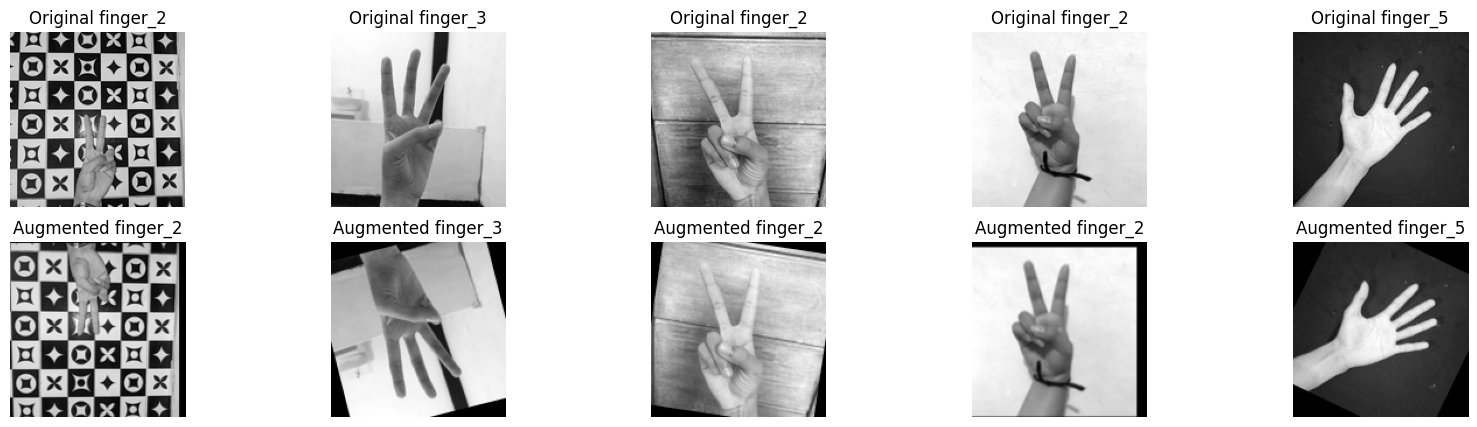

In [5]:
import random

# Fungsi untuk menerapkan rotasi
def rotate_image(image, angle):
    center = (image.shape[1] // 2, image.shape[0] // 2)
    matrix = cv.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv.warpAffine(image, matrix, (image.shape[1], image.shape[0]))
    return rotated

# Fungsi untuk menerapkan dilasi
def dilate_image(image, kernel_size=(5, 5)):
    kernel = np.ones(kernel_size, np.uint8)
    dilated = cv.dilate(image, kernel, iterations=1)
    return dilated

# Fungsi untuk menerapkan mirror (flip)
def flip_image(image, flip_code):
    flipped = cv.flip(image, flip_code)
    return flipped

# Fungsi untuk menerapkan translasi
def translate_image(image, tx, ty):
    matrix = np.float32([[1, 0, tx], [0, 1, ty]])
    translated = cv.warpAffine(image, matrix, (image.shape[1], image.shape[0]))
    return translated

# Fungsi untuk melakukan augmentasi gambar secara acak
def augment_image(image):
    augmentations = [
        lambda img: rotate_image(img, random.uniform(-30, 30)),
        lambda img: dilate_image(img),
        lambda img: flip_image(img, 1),  # Horizontal flip
        lambda img: flip_image(img, 0),  # Vertical flip
        lambda img: translate_image(img, random.uniform(-10, 10), random.uniform(-10, 10))
    ]
    num_augmentations = random.randint(1, 3)
    augmented_image = image.copy()
    for _ in range(num_augmentations):
        aug = random.choice(augmentations)
        augmented_image = aug(augmented_image)
    return augmented_image

# Fungsi utama untuk memproses dataset
def process_dataset(folders, num_samples_to_show=5):
    data = []
    data_labels = []
    augmented_data = []
    
    for folder in folders:
        label = os.path.basename(folder[:-1])
        if not os.path.exists(folder):
            print(f"Folder {folder} tidak ditemukan.")
            continue
        dataset = os.listdir(folder)
        for file in dataset:
            img_path = os.path.join(folder, file)
            name = os.path.splitext(file)[0]
            temp = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
            if temp is None:
                print(f"Gagal membaca gambar {img_path}")
                continue
            data.append(temp)
            data_labels.append(label)
            augmented_data.append(augment_image(temp))
    
    # Tampilkan beberapa gambar asli dan hasil augmentasi secara acak
    num_samples = min(num_samples_to_show, len(augmented_data))
    sampled_indices = random.sample(range(len(augmented_data)), num_samples)
    
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 5))
    for i, idx in enumerate(sampled_indices):
        axes[0, i].imshow(data[idx], cmap='gray')
        axes[0, i].set_title(f'Original {data_labels[idx]}')
        axes[0, i].axis('off')
        axes[1, i].imshow(augmented_data[idx], cmap='gray')
        axes[1, i].set_title(f'Augmented {data_labels[idx]}')
        axes[1, i].axis('off')
    plt.show()

process_dataset(folders)

### Preprocessing

#### Preprocessing 1

In [6]:
def equalize_image(image):
    equalized = cv.equalizeHist(image)
    return equalized

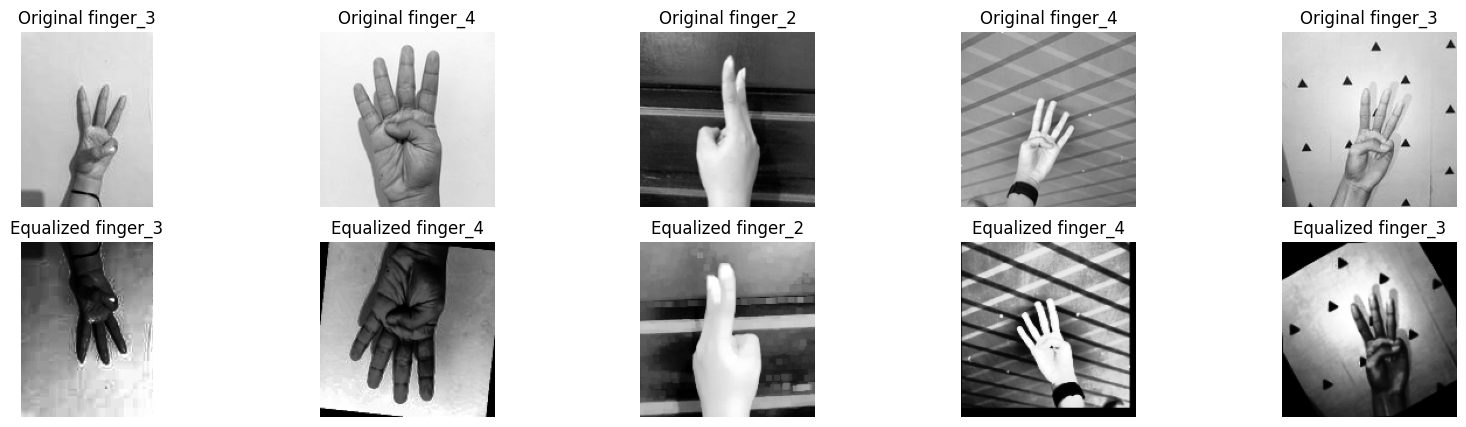

In [7]:
def process_dataset(folders, num_samples_to_show=5):
    data = []
    data_labels = []
    augmented_data = []
    equalized_data = []
    
    for folder in folders:
        label = os.path.basename(folder[:-1])
        if not os.path.exists(folder):
            print(f"Folder {folder} tidak ditemukan.")
            continue
        dataset = os.listdir(folder)
        for file in dataset:
            img_path = os.path.join(folder, file)
            name = os.path.splitext(file)[0]
            temp = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
            if temp is None:
                print(f"Gagal membaca gambar {img_path}")
                continue
            data.append(temp)
            data_labels.append(label)
            augmented_img = augment_image(temp)
            augmented_data.append(augmented_img)
            equalized_img = equalize_image(augmented_img)
            equalized_data.append(equalized_img)
    
    # Tampilkan beberapa gambar asli, hasil augmentasi, hasil ekualisasi, dan hasil deteksi tepi secara acak
    num_samples = min(num_samples_to_show, len(equalized_data))
    sampled_indices = random.sample(range(len(equalized_data)), num_samples)
    
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 5))
    for i, idx in enumerate(sampled_indices):
        axes[0, i].imshow(data[idx], cmap='gray')
        axes[0, i].set_title(f'Original {data_labels[idx]}')
        axes[0, i].axis('off')
        axes[1, i].imshow(equalized_data[idx], cmap='gray')
        axes[1, i].set_title(f'Equalized {data_labels[idx]}')
        axes[1, i].axis('off')
    plt.show()

process_dataset(folders)

#### Preprocessing 2

In [8]:
def edge_detection(image):
    edges = cv.Canny(image, 100, 200)
    return edges

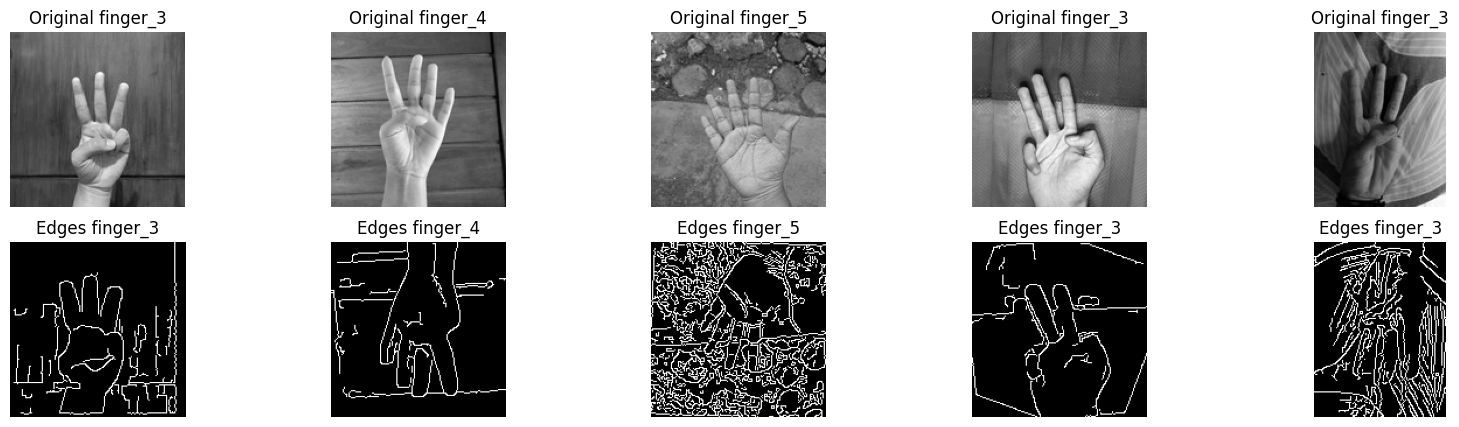

In [9]:
def process_dataset(folders, num_samples_to_show=5):
    data = []
    data_labels = []
    augmented_data = []
    equalized_data = []
    edge_detected_data = []
    
    for folder in folders:
        label = os.path.basename(folder[:-1])
        if not os.path.exists(folder):
            print(f"Folder {folder} tidak ditemukan.")
            continue
        dataset = os.listdir(folder)
        for file in dataset:
            img_path = os.path.join(folder, file)
            name = os.path.splitext(file)[0]
            temp = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
            if temp is None:
                print(f"Gagal membaca gambar {img_path}")
                continue
            data.append(temp)
            data_labels.append(label)
            augmented_img = augment_image(temp)
            augmented_data.append(augmented_img)
            equalized_img = equalize_image(augmented_img)
            equalized_data.append(equalized_img)
            edges_img = edge_detection(equalized_img)
            edge_detected_data.append(edges_img)
    
    # Tampilkan beberapa gambar asli, hasil augmentasi, hasil ekualisasi, dan hasil deteksi tepi secara acak
    num_samples = min(num_samples_to_show, len(edge_detected_data))
    sampled_indices = random.sample(range(len(edge_detected_data)), num_samples)
    
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 5))
    for i, idx in enumerate(sampled_indices):
        axes[0, i].imshow(data[idx], cmap='gray')
        axes[0, i].set_title(f'Original {data_labels[idx]}')
        axes[0, i].axis('off')
        axes[1, i].imshow(edge_detected_data[idx], cmap='gray')
        axes[1, i].set_title(f'Edges {data_labels[idx]}')
        axes[1, i].axis('off')
    plt.show()

process_dataset(folders)

### Feature Extraction

In [10]:
def is_index_valid(arr, i, j):
    return 0<=i<len(arr) and 0<=j<len(arr[0])

In [11]:
def normDegree(image):
    sum = np.sum(image)
    result = np.zeros(image.shape)
    result = image/sum
    return result

In [12]:
def degree0(image):
    result = np.zeros(image.shape)

In [16]:
def derajat0(image):
    result = np.zeros((256, 256))
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if is_index_valid(image, i, j+1):
                result[image[i,j], image[i, j+1]] += 1
    result = result+result.T
    result = normDegree(result)
    return result

def derajat45(image):
    result = np.zeros((256, 256))
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if is_index_valid(image, i-1, j+1):
                result[image[i,j], image[i-1, j+1]] += 1
    result = result+result.T
    result = normDegree(result)
    return result

def derajat90(image):
    result = np.zeros((256, 256))
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if is_index_valid(image, i-1, j):
                result[image[i,j], image[i-1, j]] += 1
    result = result+result.T
    result = normDegree(result)
    return result

def derajat135(image):
    result = np.zeros((256, 256))
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if is_index_valid(image, i-1, j-1):
                result[image[i,j], image[i-1, j-1]] += 1
    result = result+result.T
    result = normDegree(result)
    return result

In [17]:
def contrast(matriks):
    result = 0
    for i in range(matriks.shape[0]):
        for j in range(matriks.shape[1]):
            result += (i-j)**2 * matriks[i, j]
    return result

def dissimilarity(matriks):
    result = 0
    for i in range(matriks.shape[0]):
        for j in range(matriks.shape[1]):
            result += abs(i-j) * matriks[i, j]
    return result

def homogenity(matriks):
    result = 0
    for i in range(matriks.shape[0]):
        for j in range(matriks.shape[1]):
            result += matriks[i, j] / (1 + abs(i-j))
    return result

def entropy(matriks):
    result = 0
    for i in range(matriks.shape[0]):
        for j in range(matriks.shape[1]):
            if matriks[i, j] != 0:
                result -= matriks[i, j] * np.log2(matriks[i, j])
    return result

def asm(matriks):
    result = np.sum(matriks**2)
    return result

def energy(matriks):
    result = np.sqrt(np.sum(matriks**2))
    return result

def idxMiu(matriks):
    row, col = matriks.shape
    indices_i, indices_j = np.indices((row, col))
    miu_i = np.sum(indices_i * matriks)
    miu_j = np.sum(indices_j * matriks)
    return miu_i, miu_j

def standartDeviation(matriks):
    row, col = matriks.shape
    indices_i, indices_j = np.indices((row, col))
    miu_i, miu_j = idxMiu(matriks)
    standartDev_i = np.sqrt(np.sum((indices_i - miu_i)**2 * matriks))
    standartDev_j = np.sqrt(np.sum((indices_j - miu_j)**2 * matriks))
    return standartDev_i, standartDev_j

def correlation(matriks):
    row, col = matriks.shape
    indices_i, indices_j = np.indices((row, col))
    miu_i, miu_j = idxMiu(matriks)
    standartDev_i, standartDev_j = standartDeviation(matriks)
    result = np.sum((indices_i - miu_i) * (indices_j - miu_j) * matriks) / (standartDev_i * standartDev_j)
    return result

In [18]:
degree_0 = []
degree_45 = []
degree_90 = []
degree_135 = []
for i in range(len(data)):
    temp0 = derajat0(data[i])
    temp45 = derajat45(data[i])
    temp90 = derajat90(data[i])
    temp135 = derajat135(data[i])
    degree_0.append(temp0)
    degree_45.append(temp45)
    degree_90.append(temp90)
    degree_135.append(temp135)

NameError: name 'preprocess_data' is not defined

In [ ]:
contrast0 = []
contrast45 = []
contrast90 = []
contrast135 = []
for i in range(len(data)):
    temp0 = contrast(degree_0[i])
    temp45 = contrast(degree_45[i])
    temp90 = contrast(degree_90[i])
    temp135 = contrast(degree_135[i])
    contrast0.append(temp0)
    contrast45.append(temp45)
    contrast90.append(temp90)
    contrast135.append(temp135)

In [ ]:
dissimilarity0 = []
dissimilarity45 = []
dissimilarity90 = []
dissimilarity135 = []
for i in range(len(data)):
    temp0 = dissimilarity(degree_0[i])
    temp45 = dissimilarity(degree_45[i])
    temp90 = dissimilarity(degree_90[i])
    temp135 = dissimilarity(degree_135[i])
    dissimilarity0.append(temp0)
    dissimilarity45.append(temp45)
    dissimilarity90.append(temp90)
    dissimilarity135.append(temp135)

In [ ]:
homogenity0 = []
homogenity45 = []
homogenity90 = []
homogenity135 = []
for i in range(len(data)):
    temp0 = homogenity(degree_0[i])
    temp45 = homogenity(degree_45[i])
    temp90 = homogenity(degree_90[i])
    temp135 = homogenity(degree_135[i])
    homogenity0.append(temp0)
    homogenity45.append(temp45)
    homogenity90.append(temp90)
    homogenity135.append(temp135)

In [ ]:
energy0 = []
energy45 = []
energy90 = []
energy135 = []
for i in range(len(data)):
    temp0 = energy(degree_0[i])
    temp45 = energy(degree_45[i])
    temp90 = energy(degree_90[i])
    temp135 = energy(degree_135[i])
    energy0.append(temp0)
    energy45.append(temp45)
    energy90.append(temp90)
    energy135.append(temp135)

In [ ]:
correlation0 = []
correlation45 = []
correlation90 = []
correlation135 = []
for i in range(len(data)):
    temp0 = correlation(degree_0[i])
    temp45 = correlation(degree_45[i])
    temp90 = correlation(degree_90[i])
    temp135 = correlation(degree_135[i])
    correlation0.append(temp0)
    correlation45.append(temp45)
    correlation90.append(temp90)
    correlation135.append(temp135)

In [ ]:
entropy0 = []
entropy45 = []
entropy90 = []
entropy135 = []
for i in range(len(data)):
    temp0 = entropy(degree_0[i])
    temp45 = entropy(degree_45[i])
    temp90 = entropy(degree_90[i])
    temp135 = entropy(degree_135[i])
    entropy0.append(temp0)
    entropy45.append(temp45)
    entropy90.append(temp90)
    entropy135.append(temp135)

In [ ]:
asm0 = []
asm45 = []
asm90 = []
asm135 = []
for i in range(len(data)):
    temp0 = asm(degree_0[i])
    temp45 = asm(degree_45[i])
    temp90 = asm(degree_90[i])
    temp135 = asm(degree_135[i])
    asm0.append(temp0)
    asm45.append(temp45)
    asm90.append(temp90)
    asm135.append(temp135)

In [ ]:
pd.DataFrame({
    'contrast0': contrast0,
    'contrast45': contrast45,
    'contrast90': contrast90,
    'contrast135': contrast135,
    'dissimilarity0': dissimilarity0,
    'dissimilarity45': dissimilarity45,
    'dissimilarity90': dissimilarity90,
    'dissimilarity135': dissimilarity135,
    'homogenity0': homogenity0,
    'homogenity45': homogenity45,
    'homogenity90': homogenity90,
    'homogenity135': homogenity135,
    'energy0': energy0,
    'energy45': energy45,
    'energy90': energy90,
    'energy135': energy135,
    'correlation0': correlation0,
    'correlation45': correlation45,
    'correlation90': correlation90,
    'correlation135': correlation135,
    'entropy0': entropy0,
    'entropy45': entropy45,
    'entropy90': entropy90,
    'entropy135': entropy135,
    'asm0': asm0,
    'asm45': asm45,
    'asm90': asm90,
    'asm135': asm135
})
# }) .to_csv('feature_ekstraction.csv')

### Features Selection

### Splitting Data

### Normalization

## Modeling

## Evaluation